In [1]:
#library imports
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [120]:
# Here we need to change the path
images_path = Path('./images')
anno_path = Path('./annotations')

In [121]:
df_train = pd.read_csv("./training_frames_keypoints.csv")
df_train=df_train.rename(columns = {'Unnamed: 0':'path'})

In [122]:
df_train

,path,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [130]:
import torchvision.transforms.v2 as transforms

In [131]:
from transform import Rescale

# Exactly the same interface as V1:
trans = transforms.Compose([
    Rescale(224),
])

In [132]:
#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

In [157]:
row = df_train.iloc[0]

In [158]:
import matplotlib.image as mpimg


./training/Luis_Fonsi_21.jpg


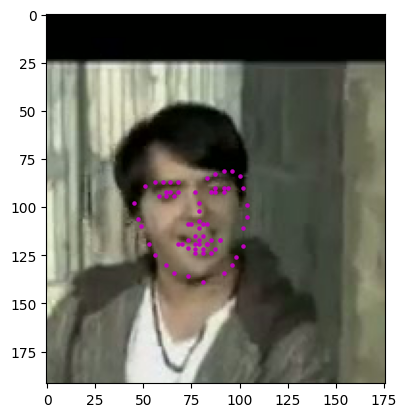

In [159]:
print("./training/" + str(row["path"]))
im = read_image("./training/" + str(row["path"]))

keypoints = row.iloc[1:].values  # ignore column name
# Convert the flatten version to a set of (x, y) coordinates
key_pts = keypoints.astype("float").reshape(-1, 2)
sample = {"image": im, "keypoints": key_pts}

plt.imshow(im)
plt.scatter(key_pts[:, 0], key_pts[:, 1], s=20, marker=".", c="m")

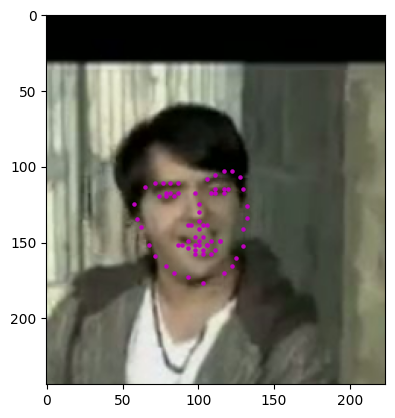

In [160]:

# The same transforms can be used!

data = trans(sample)

img_new = data["image"]
keypoints_new = data["keypoints"]

plt.scatter(keypoints_new[:, 0], keypoints_new[:, 1], s=20, marker=".", c="m")
plt.imshow(img_new)



In [161]:
print(keypoints_new.shape)

keypoints_new = keypoints_new.reshape(-1)

print(keypoints_new.shape)


(68, 2)
(136,)


In [180]:
df_train_resized = pd.DataFrame(columns=df_train.columns)

#Populating Training DF with new paths and bounding boxes
new_paths = []
new_keypoints = []
# here we need to create folder and change the path
train_path_resized = Path('./training_resized/')


for index, row in df_train.iterrows():  
    print("./training/" + str(row["path"]))
    im = mpimg.imread("./training/" + str(row["path"]))
    
    keypoints = np.array(row[1:])
    # Convert the flatten version to a set of (x, y) coordinates
    key_pts = keypoints.astype("float").reshape(-1, 2)
    sample = {"image": im, "keypoints": key_pts}

    img_new = sample["image"]
    keypoints_new = sample["keypoints"].reshape(-1)

    new_path = "./training_reshaped/" + str(row["path"])

    #Saving the new image
    mpimg.imsave(new_path, img_new)

    new_row = [str(row["path"])] + keypoints_new.tolist()
    df_train_resized.loc[index] = new_row

df_train_resized.to_csv("./training_frames_keypoints_resized.csv", index=False)

./training/Luis_Fonsi_21.jpg
./training/Lincoln_Chafee_52.jpg
./training/Valerie_Harper_30.jpg
./training/Angelo_Reyes_22.jpg
./training/Kristen_Breitweiser_11.jpg
./training/Albert_Brooks_12.jpg
./training/Daniel_Radcliffe_02.jpg
./training/Laura_Bozzo_41.jpg
./training/James_Hoffa_51.jpg
./training/Christopher_Walken_20.jpg
./training/Paul_Otellini_01.jpg
./training/Linda_Franklin_01.jpg
./training/Wayne_Gretzky_41.jpg
./training/Edward_Burns_11.jpg
./training/Flavia_Pennetta_32.jpg
./training/Robbie_Coltrane_10.jpg
./training/T_Boone_Pickens_31.jpg
./training/Richard_Paul_Evans_00.jpg
./training/Cristina_Saralegui_31.jpg
./training/Elsa_Zylberstein_00.jpg
./training/Sanjay_Gupta_11.jpg
./training/George_Galloway_21.jpg
./training/Sally_Ride_02.jpg
./training/Linda_Franklin_12.jpg
./training/Daniel_Radcliffe_01.jpg
./training/Alejandro_Toledo_52.jpg
./training/Alfredo_di_Stefano_01.jpg
./training/Peter_Medgyessy_50.jpg
./training/Daisy_Fuentes_30.jpg
./training/Andy_Roddick_40.jpg
./

In [181]:
df_train_resized

,path,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,Luis_Fonsi_21.jpg,45.0,98.0,47.0,106.0,49.0,110.0,53.0,119.0,56.0,...,83.0,119.0,90.0,117.0,83.0,119.0,81.0,122.0,77.0,122.0
1,Lincoln_Chafee_52.jpg,41.0,83.0,43.0,91.0,45.0,100.0,47.0,108.0,51.0,...,85.0,122.0,94.0,120.0,85.0,122.0,83.0,122.0,79.0,122.0
2,Valerie_Harper_30.jpg,56.0,69.0,56.0,77.0,56.0,86.0,56.0,94.0,58.0,...,79.0,105.0,86.0,108.0,77.0,105.0,75.0,105.0,73.0,105.0
3,Angelo_Reyes_22.jpg,61.0,80.0,58.0,95.0,58.0,108.0,58.0,120.0,58.0,...,98.0,136.0,107.0,139.0,95.0,139.0,91.0,139.0,85.0,136.0
4,Kristen_Breitweiser_11.jpg,58.0,94.0,58.0,104.0,60.0,113.0,62.0,121.0,67.0,...,92.0,117.0,103.0,118.0,92.0,120.0,88.0,122.0,84.0,122.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3457,Thomas_Ferguson_02.jpg,35.0,94.0,35.0,105.0,38.0,112.0,40.0,123.0,46.0,...,71.0,123.0,79.0,121.0,71.0,123.0,66.0,126.0,64.0,126.0
3458,Valerie_Harper_00.jpg,72.0,133.0,76.0,147.0,80.0,159.0,87.0,170.0,91.0,...,120.0,156.0,135.0,159.0,124.0,163.0,117.0,167.0,113.0,166.0
3459,Maggie_Smith_00.jpg,52.0,149.0,56.0,160.0,63.0,168.0,71.0,179.0,78.0,...,122.0,169.0,133.0,169.0,122.0,172.0,115.0,172.0,111.0,172.0
3460,Erin_Hershey_Presley_41.jpg,82.0,91.0,82.0,105.0,82.0,116.0,86.0,128.0,90.0,...,119.0,132.0,134.0,136.0,119.0,139.0,112.0,139.0,108.0,139.0


In [169]:
df_test = pd.read_csv("./test_frames_keypoints.csv")
df_test=df_test.rename(columns = {'Unnamed: 0':'path'})

In [170]:
df_test

,path,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
0,James_Wolfensohn_00.jpg,25.0,44.0,25.0,49.0,25.0,54.0,25.0,59.0,26.0,...,42.0,65.0,46.0,65.0,42.0,65.0,39.0,65.0,38.0,65.0
1,Valerie_Harper_30.jpg,55.0,62.0,52.0,72.0,52.0,83.0,55.0,90.0,55.0,...,78.0,104.0,88.0,106.0,78.0,106.0,75.0,104.0,70.0,104.0
2,Kristen_Breitweiser_11.jpg,60.0,88.0,60.0,98.0,63.0,109.0,65.0,116.0,68.0,...,96.0,114.0,106.0,117.0,96.0,117.0,94.0,117.0,89.0,117.0
3,Elizabeth_Dole_31.jpg,41.0,96.0,43.0,104.0,47.0,113.0,49.0,120.0,56.0,...,98.0,118.0,103.0,118.0,98.0,120.0,96.0,122.0,94.0,122.0
4,Kit_Bond_20.jpg,35.0,67.0,37.0,74.0,41.0,81.0,44.0,87.0,48.0,...,76.0,96.0,83.0,93.0,76.0,98.0,73.0,98.0,69.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,Massoud_Barzani_10.jpg,95.0,123.0,95.0,136.0,97.0,146.0,100.0,157.0,102.0,...,143.0,160.0,154.0,160.0,143.0,160.0,138.0,160.0,133.0,160.0
766,Olivia_Newton-John_10.jpg,81.0,112.0,81.0,125.0,84.0,137.0,87.0,149.0,90.0,...,139.0,156.0,148.0,159.0,139.0,159.0,133.0,159.0,130.0,159.0
767,Erin_Hershey_Presley_41.jpg,80.0,94.0,80.0,106.0,80.0,118.0,83.0,130.0,86.0,...,113.0,134.0,129.0,140.0,113.0,143.0,107.0,143.0,104.0,140.0
768,James_Wolfensohn_50.jpg,20.0,107.0,23.0,122.0,27.0,133.0,31.0,148.0,42.0,...,108.0,142.0,115.0,142.0,108.0,146.0,104.0,145.0,100.0,145.0


In [185]:
df_train_resized.to_csv("./training_frames_keypoints_resized.csv", index=False)

In [182]:
df_test_resized = pd.DataFrame(columns=df_test.columns)

#Populating testing DF with new paths and bounding boxes
new_paths = []
new_keypoints = []
# here we need to create folder and change the path
test_path_resized = Path('./test_resized/')


for index, row in df_test.iterrows():  
    print("./test/" + str(row["path"]))
    im = mpimg.imread("./test/" + str(row["path"]))
    
    keypoints = np.array(row[1:])
    # Convert the flatten version to a set of (x, y) coordinates
    key_pts = keypoints.astype("float").reshape(-1, 2)
    sample = {"image": im, "keypoints": key_pts}

    img_new = sample["image"]
    keypoints_new = sample["keypoints"].reshape(-1)

    new_path = "./test_reshaped/" + str(row["path"])

    #Saving the new image
    mpimg.imsave(new_path, img_new)

    new_row = [str(row["path"])] + keypoints_new.tolist()
    df_test_resized.loc[index] = new_row

df_test_resized.to_csv("./test_frames_keypoints_resized.csv", index=False)

./test/James_Wolfensohn_00.jpg
./test/Valerie_Harper_30.jpg
./test/Kristen_Breitweiser_11.jpg
./test/Elizabeth_Dole_31.jpg
./test/Kit_Bond_20.jpg
./test/Laura_Bozzo_41.jpg
./test/Carlos_Ghosn_41.jpg
./test/Tessa_Jowell_20.jpg
./test/Wes_Craven_31.jpg
./test/Tim_Pawlenty_00.jpg
./test/Linda_Franklin_01.jpg
./test/Adam_Sandler_01.jpg
./test/Louis_Van_Gaal_10.jpg
./test/Isabella_Rossellini_10.jpg
./test/Carlos_Menem_31.jpg
./test/James_Hoffa_20.jpg
./test/Richard_Paul_Evans_21.jpg
./test/Richard_Paul_Evans_00.jpg
./test/William_Donaldson_10.jpg
./test/Charlotte_Casiraghi_21.jpg
./test/Colin_Powell_40.jpg
./test/George_Galloway_21.jpg
./test/Danny_Glover_30.jpg
./test/Alejandro_Toledo_50.jpg
./test/Lester_Holt_41.jpg
./test/Olene_Walker_01.jpg
./test/Alfredo_di_Stefano_01.jpg
./test/Ed_Rendell_20.jpg
./test/Sanjay_Gupta_20.jpg
./test/Alvaro_Silva_Calderon_00.jpg
./test/Natasha_Lyonne_41.jpg
./test/Daisy_Fuentes_30.jpg
./test/Richard_Lennon_30.jpg
./test/Kirsten_Dunst_31.jpg
./test/Marissa_

In [184]:
df_test_resized.to_csv("./test_frames_keypoints_resized.csv", index=False)